In [12]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, time, timedelta
import warnings
import os
from tqdm import tqdm

warnings.filterwarnings('ignore')  # 过滤不必要的warnings
plt.rcParams["font.sans-serif"] = ['Hiragino Sans GB']  # set font
plt.rcParams["axes.unicode_minus"] = False  # solve "-"

In [13]:
''' 基本参数 '''
list_color = ['#044E7E', '#FF3333', '#367198', '#FF8080', '#81A6BE', '#FFB2B2', '#000000', '#999999','#666633','#996633']

begin_date = '2004-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')  

index_code = '000300.SH' # 沪深300代码

file_path = '/Users/tommylxt/Desktop/算法交易hw/PCR因子'

In [14]:
''' 指数期权数据 '''
data_1 = pd.read_pickle(f'{file_path}/ChinaOptionDescription.pkl')
data_2 = pd.read_pickle(f'{file_path}/ChinaOptionEODPrices.pkl')

''' 无风险利率数据 '''
df_bond_index = pd.read_excel(f'{file_path}/df_bond_index_pct.xlsx')
df_bond_index.rename(columns={'日期': '交易日期'}, inplace=True)

''' 指数数据 '''
df_index = pd.read_excel(f'{file_path}/df_000300.SH_data.xlsx')
df_index.rename(columns={'日期': '交易日期'}, inplace=True)

df_1 = pd.DataFrame(data_1)
df_2 = pd.DataFrame(data_2)

In [15]:
''' 期权数据整理 '''
df_1.rename(columns = {
          'S_INFO_WINDCODE':'月合约wind代码', 'S_INFO_CODE':'月合约交易所编码',
          'S_INFO_NAME':'月合约全称', 'S_INFO_SCCODE':'期权wind代码','S_INFO_CALLPUT':'月合约类别',
          'S_INFO_MONTH':'交割月份', 'S_INFO_MATURITYDATE':'到期日','S_INFO_FTDATE':'开始交易日',
          'S_INFO_LASTTRADINGDATE':'最后交易日', 'S_INFO_EXERCISINGEND':'最后行权日',
          'S_INFO_LDDATE':'最后交割日'
          },inplace=True)

df_1 = df_1.loc[:, ['月合约wind代码', '月合约交易所编码', '月合约全称', '期权wind代码', '月合约类别',
                   '交割月份', '到期日', '开始交易日', '最后交易日', '最后行权日','最后交割日'
                   ]]
keywords=['华泰柏瑞沪深300ETF']
matched_df_1 = []

# 对每个关键词进行搜索
for keyword in keywords:
    # 过滤包含关键词的行
    matched_rows = df_1[df_1['月合约全称'].str.contains(keyword, na=False)]
    # 将匹配的DataFrame添加到列表中
    matched_df_1.append(matched_rows)

# 使用concat合并所有匹配的DataFrame
df_1 = pd.concat(matched_df_1, ignore_index=True)

df_2.rename(columns = {
          'S_INFO_WINDCODE':'wind代码', 'TRADE_DT':'交易日期',
          'S_DQ_VOLUME':'成交量','S_DQ_AMOUNT':'成交额',
          'S_DQ_OI':'持仓量'},inplace=True)

df_2 = df_2.loc[:, ['wind代码', '交易日期', '成交量', '成交额', '持仓量']]

# 将df_1中有的期权从df_2中选出来，并且确定它的合约类别
# 确定df_1中“月合约wind代码”列的唯一代码
unique_codes = df_1['月合约wind代码'].unique()

# 在df_2中过滤出包含这些代码的行
df_2 = df_2[df_2['wind代码'].isin(unique_codes)]

# 将df_1中的'月合约wind代码', '月合约全称', '月合约类别'三列合并到df_2
df_merged = df_2.merge(df_1[['月合约wind代码', '月合约全称', '月合约类别']], 
                       left_on='wind代码', right_on='月合约wind代码', 
                       how='left')

# 修改月合约类别 ‘708001000’修改为‘call', ‘708002000’修改为‘put'
df_merged['月合约类别'].replace({708001000 : 'call', 708002000 : 'put'}, inplace=True)

# 按照交易日期排序，然后是月合约类别，使得同一日期的数据聚集，同时put和call也分别聚集
df_sorted = df_merged.sort_values(by=['交易日期', '月合约类别'], ascending=[True, False])

df_hushen300 = df_sorted[df_sorted['月合约全称'].str.contains('沪深300ETF', na=False)]
df_hushen300.head()

,wind代码,交易日期,成交量,成交额,持仓量,月合约wind代码,月合约全称,月合约类别
99312,10002130.SH,20191223,45404.0000,2391.6246,17779.0000,10002130.SH,华泰柏瑞沪深300ETF期权2001认沽4.00,put
99315,10002131.SH,20191223,15354.0000,1691.3104,4631.0000,10002131.SH,华泰柏瑞沪深300ETF期权2001认沽4.10,put
99349,10002134.SH,20191223,2605.0000,951.3849,610.0000,10002134.SH,华泰柏瑞沪深300ETF期权2001认沽4.40,put
99351,10002188.SH,20191223,2002.0000,764.4867,966.0000,10002188.SH,华泰柏瑞沪深300ETF期权2006认沽4.40,put
99353,10002132.SH,20191223,3997.0000,738.5967,577.0000,10002132.SH,华泰柏瑞沪深300ETF期权2001认沽4.20,put


In [16]:
''' 因子计算 '''
def calculate_PCR(df):
    '''
    用于计算df中put和call的总成交量、总成交额、总持仓量以及对应的PCR
    :param df: 指数期权的相关数据
    :return: 算出PCR后合并的dataframe
    '''
    put_df = df[df['月合约类别'] == 'put'].groupby('交易日期').agg({
        '成交量': 'sum',
        '成交额': 'sum',
        '持仓量': 'sum'
    }).rename(columns={
        '成交量': 'put成交量',
        '成交额': 'put成交额',
        '持仓量': 'put持仓量'
    })

    call_df = df[df['月合约类别'] == 'call'].groupby('交易日期').agg({
        '成交量': 'sum',
        '成交额': 'sum',
        '持仓量': 'sum'
    }).rename(columns={
        '成交量': 'call成交量',
        '成交额': 'call成交额',
        '持仓量': 'call持仓量'
    })

    # 合并 put 和 call 的数据
    combined_df = pd.merge(put_df, call_df, left_index=True, right_index=True)

    # 计算 put/call ratio
    combined_df['put_call_ratio_volume'] = combined_df['put成交量'] / combined_df['call成交量']
    combined_df['put_call_ratio_amount'] = combined_df['put成交额'] / combined_df['call成交额']
    combined_df['put_call_ratio_oi'] = combined_df['put持仓量'] / combined_df['call持仓量']
    
    # 保存到新的DataFrame
    combined_df = combined_df.reset_index()
    return combined_df

combined_df_hushen300 = calculate_PCR(df_hushen300)
combined_df_hushen300['交易日期'] = pd.to_datetime(combined_df_hushen300['交易日期'])
combined_df_hushen300.head()

,交易日期,put成交量,put成交额,put持仓量,call成交量,call成交额,call持仓量,put_call_ratio_volume,put_call_ratio_amount,put_call_ratio_oi
0,2019-12-23,193530.0000,12983.8786,73071.0000,275182.0000,29561.3618,107629.0000,0.7032800110472341940969976234,0.4392178779801680178346858161,0.6789155339174386085534567821
1,2019-12-24,141566.0000,7046.9804,118991.0000,186105.0000,10009.4573,161726.0000,0.7606781118185970285591467183,0.7040322156127285742055166168,0.7357567738026044049812646080
2,2019-12-25,229629.0000,10331.7855,175600.0000,275320.0000,14652.5070,227329.0000,0.8340440215022519250326892343,0.7051206663815277481184619124,0.7724487416915571704445979176
3,2019-12-26,283556.0000,13322.4300,228595.0000,329510.0000,19580.1901,280215.0000,0.8605383751631209978452854238,0.6804035063990517640582049303,0.8157843084774191246007529932
4,2019-12-27,436734.0000,21614.9587,282926.0000,553764.0000,39447.1659,327580.0000,0.7886644852319760764513402821,0.5479470630360291612229612673,0.8636852066670736919225837963


In [17]:
df_factor = combined_df_hushen300[['交易日期', 'put_call_ratio_volume']]
df_factor = pd.merge(df_factor, df_bond_index[['交易日期', 'bond_index_pct']], on='交易日期', how='left')
df_factor = pd.merge(df_factor, df_index[['交易日期', 'index_close']], on='交易日期', how='left')
df_factor.set_index('交易日期', inplace=True)

df_factor.head()

,put_call_ratio_volume,bond_index_pct,index_close
交易日期,,,
2019-12-23,0.7032800110472341940969976234,0.000988,3967.0962
2019-12-24,0.7606781118185970285591467183,0.000606,3992.9581
2019-12-25,0.8340440215022519250326892343,0.000444,3990.8671
2019-12-26,0.8605383751631209978452854238,0.000825,4025.9879
2019-12-27,0.7886644852319760764513402821,0.000104,4022.0278


In [18]:
''' 开仓信号 '''
def percentile_method_position(df, column, rolling_days, rolling_percentile):    
    # 计算滚动百分位
    df['rolling_percentile'] = df[column].rolling(window=rolling_days).apply(lambda x: x.rank(pct=True).iloc[-1], raw=False)
    
    # 初始化position列
    df['position'] = np.nan
    
    # 根据滚动百分位设置position的值
    df.loc[df['rolling_percentile'] >= rolling_percentile, 'position'] = 1
    df.loc[df['rolling_percentile'] <= rolling_percentile, 'position'] = -1
    df['position'] = df['position'].shift(1)
    df['position'].fillna(method='ffill', inplace=True)
    df.dropna(inplace=True)
    return df

rolling_days = 40
rolling_percentile = 0.9

df_position = percentile_method_position(df_factor, 'put_call_ratio_volume', rolling_days, rolling_percentile)
df_position.head()

,put_call_ratio_volume,bond_index_pct,index_close,rolling_percentile,position
交易日期,,,,,
2020-02-26,1.150048498147529774682376886,0.000428,4073.0152,0.975,1.0
2020-02-27,0.9599079772533709005001186392,0.000710,4084.8759,0.750,1.0
2020-02-28,1.262163726145774394321279770,0.000900,3940.0488,1.000,-1.0
2020-03-02,0.8623300084335355653957880172,0.000136,4069.6662,0.575,1.0
2020-03-03,0.7674322767421937313521018581,-0.000142,4091.3615,0.400,-1.0


In [19]:
''' 计算择时净值 '''
def calculate_nav(df):
    df['index_return'] = df['index_close'].pct_change()
    # position为1，持有标的；position为-1，持有十年期国债
    df['timing_return'] = df['index_return'] * (df['position'].replace(-1, 0)) \
                        - df['bond_index_pct'] * (df['position'].replace(1, 0))
    df['index_nav'] = (1 + df['index_return']).cumprod()  
    df['timing_nav'] = (1 + df['timing_return']).cumprod()  
    df.dropna(inplace=True)
    return df

calculate_nav(df_position).head()

,put_call_ratio_volume,bond_index_pct,index_close,rolling_percentile,position,index_return,timing_return,index_nav,timing_nav
交易日期,,,,,,,,,
2020-02-27,0.9599079772533709005001186392,0.000710,4084.8759,0.750,1.0,0.002912,0.002912,1.002912,1.002912
2020-02-28,1.262163726145774394321279770,0.000900,3940.0488,1.000,-1.0,-0.035454,0.000900,0.967354,1.003814
2020-03-02,0.8623300084335355653957880172,0.000136,4069.6662,0.575,1.0,0.032897,0.032897,0.999178,1.036837
2020-03-03,0.7674322767421937313521018581,-0.000142,4091.3615,0.400,-1.0,0.005331,-0.000142,1.004504,1.036690
2020-03-04,1.036387593531685520763147629,0.001046,4115.0524,0.825,-1.0,0.005790,0.001046,1.010321,1.037775


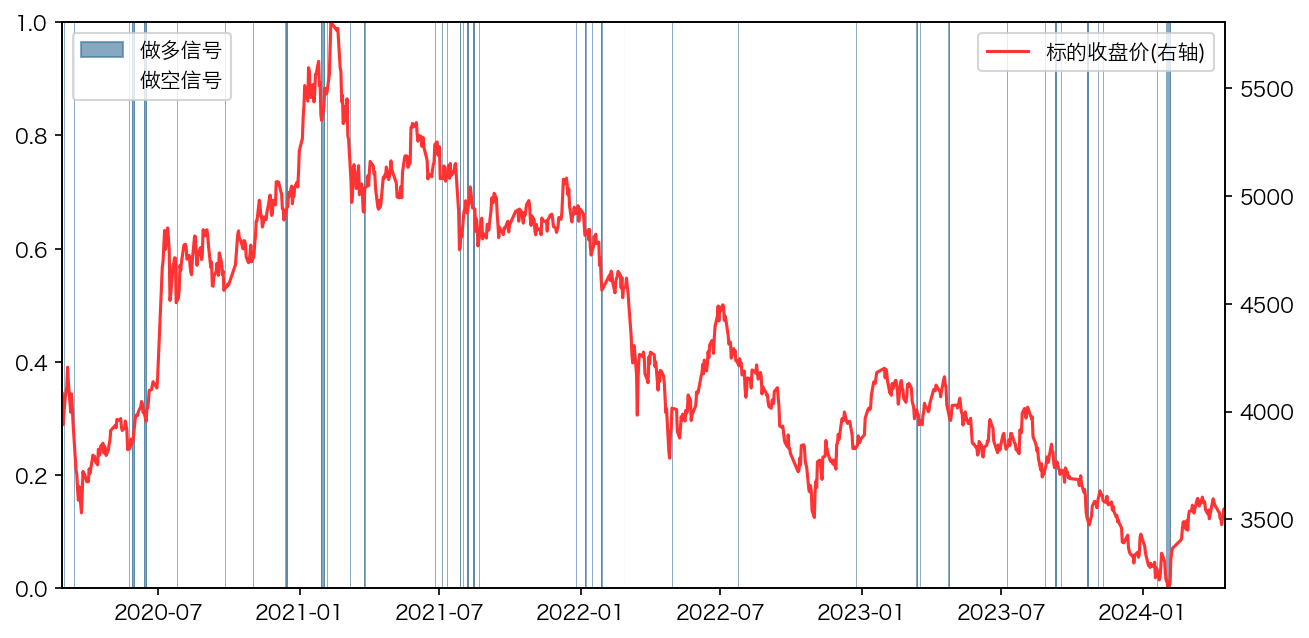

In [20]:
''' 绘制信号图 '''
def plot_signal(df):
    fig, ax1 = plt.subplots(figsize=(10, 5), dpi=150)  # 创建图形大小和分辨率。

    # 为多信号绘制蓝色区域
    ax1.fill_between(df.index, 0, 1, where=(df['position'] > 0), color=list_color[2], alpha=0.6, label='做多信号')
    # 为空信号绘制绿色区域
    ax1.fill_between(df.index, 0, 1, where=(df['position'] < 0), color='white', label='做空信号')
    
    ax1.set_xlim(df.index.min(), df.index.max())  # 设置x轴为DataFrame索引的最小值到最大值
    ax1.set_ylim(0, 1)  # 设置y轴的范围以容纳-1到1的信号
    
    # 绘制收盘价曲线
    ax2 = ax1.twinx()  # 创建与ax1共享x轴的ax2
    ax2.plot(df['index_close'], color=list_color[1], label='标的收盘价(右轴)')
    ax2.set_ylim(df['index_close'].min(), df['index_close'].max())  # 设置ax2的y轴范围以显示收盘价数据

    # 设置图例位置
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.show()
    plt.close() 
    
plot_signal(df_position)

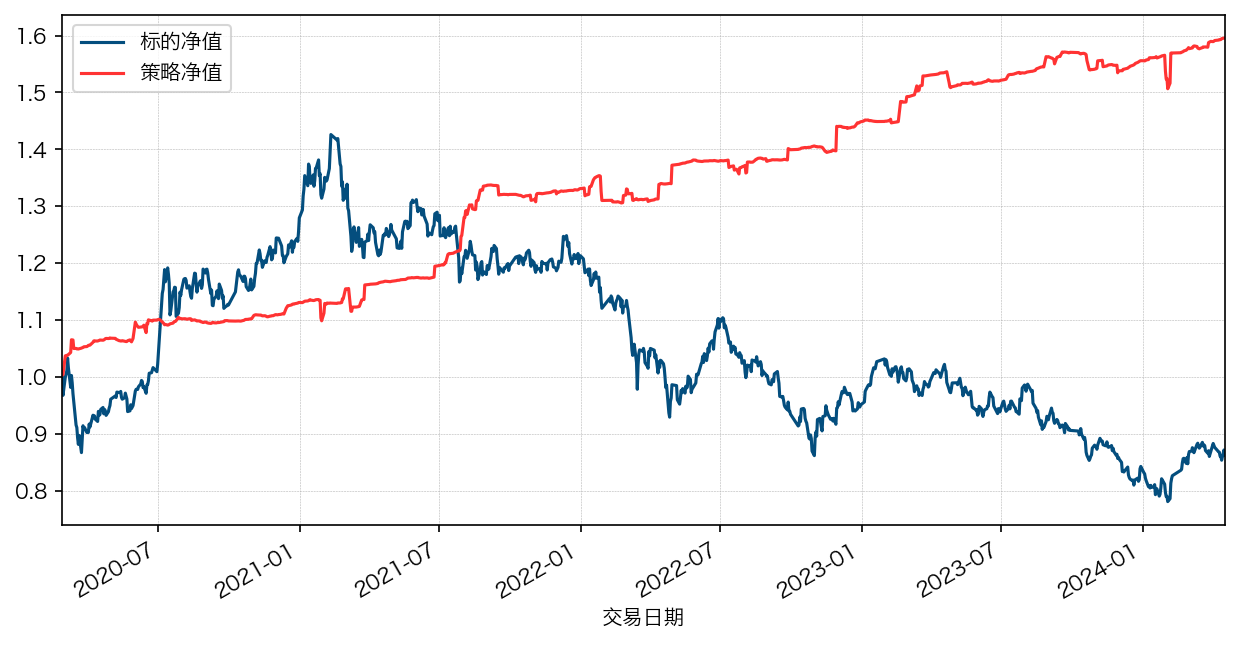

In [21]:
def plot_nav_curve(df):
    # 绘制策略表现
    fig = plt.figure(figsize=(10, 5), dpi=150)
    ax1 = fig.add_subplot(111)
    df[['index_nav', 'timing_nav']].plot(ax=ax1, color=list_color, legend=False)
    xlim = ax1.set_xlim(df.index.min(), df.index.max())
    legend = ax1.legend(['标的净值', '策略净值'])
    grid = ax1.grid(True, which='both', linestyle='--', linewidth=0.25)
    plt.show()
    
plot_nav_curve(df_position)

In [22]:
''' 计算策略效果 '''
period = 252

def calculate_strategy_effect(df, period):
    ''' 计算年化收益 '''
    initial_nav = df['timing_nav'].iloc[0]
    final_nav = df['timing_nav'].iloc[-1]
    annual_return = (final_nav / initial_nav) ** (period / (len(df) - 1)) - 1 
    
    ''' 计算年化波动率 '''    
    annual_std = df['timing_return'].std() * np.sqrt(period)
    
    ''' 计算夏普 '''
    sharpe = annual_return / annual_std
    
    ''' 计算最大回撤 '''
    df['pre_peak'] = df['timing_nav'].cummax()
    df['maximum_drawdown'] = df['timing_nav'] / df['pre_peak'] - 1
    maximum_drawdown = df['maximum_drawdown'].min()
    return annual_return, annual_std, sharpe, maximum_drawdown

strategy_effect = calculate_strategy_effect(df_position, period)

annual_return = strategy_effect[0]
annual_std = strategy_effect[1]
sharpe = strategy_effect[2]
maximum_drawdown = strategy_effect[3]

print(f'\n------------------- strategy effect ---------------------\n'
      f'annual return: {annual_return * 100:.2f}%\n'
      f'annual std: {annual_std * 100:.2f}%\n'
      f'sharpe ratio: {sharpe:.4f}\n'
      f'maximum drawdown: {maximum_drawdown * 100:.2f}%\n'
      )


------------------- strategy effect ---------------------
annual return: 12.38%
annual std: 6.39%
sharpe ratio: 1.9364
maximum drawdown: -4.12%



In [26]:
df_factor_PCR = df_factor.copy()
df_factor_PCR.reset_index(inplace=True)
df_factor_PCR.rename(columns={'交易日期': 'datetime'}, inplace=True)
df_factor_PCR = df_factor_PCR[['datetime','put_call_ratio_volume']]
df_factor_PCR.to_excel('/Users/tommylxt/Desktop/算法交易hw/相关系数/df_factor_PCR.xlsx')
print('ok')

ok
